# Loop Combiner 

An unofficial impelmentation of:
Chen, B.-Y., Smith, J. B. L. and Yang, Y.-H. (2020) ‘Neural Loop Combiner: Neural Network Models for Assessing the Compatibility of Loops’. 

# Settings

In [1]:
import torchaudio
from pathlib import Path
import itertools
from matplotlib import pyplot as plt
import os

os.environ['CUDA_VISIBLE_DEVICES']='2,3' # personal use

# CONSTANTS
SAMPLE_RATE = 44100

# Possible combinations of extracted tracks. 
TYPES_TRACK = ["drums.wav", "bass.wav", "other.wav"]
COMB_TRACK = list(itertools.combinations(TYPES_TRACK, 2))
print(COMB_TRACK)

[('drums.wav', 'bass.wav'), ('drums.wav', 'other.wav'), ('bass.wav', 'other.wav')]


# Dataset

In [2]:
import torchaudio
import torchvision
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np 
import functools
import random
import torch
from torch.utils.data import DataLoader

class LoopComb(Dataset):
    def __init__(self, path, size):
        dirs = list(Path(path).glob("*"))[:size]

        # positive pairs
        self.positives = [(os.path.join(d, t1), os.path.join(d, t2)) for d in dirs for t1, t2 in COMB_TRACK]
        self.positives = [ (t1, t2) for t1, t2 in self.positives if (os.path.exists(t1) and os.path.exists(t2))]
        print("positives #", len(self.positives))

        # random pairs
#        dirs = Path(path).glob("*")
        dirnames = list(dirs)
        self.negatives = []
        for _ in range(int(len(self.positives)/len(COMB_TRACK))):
            d1, d2 = random.choices(dirnames, k=2)
            self.negatives.extend( [(os.path.join(d1, t1), os.path.join(d2, t2)) for t1, t2 in COMB_TRACK])
        self.negatives = [ (t1, t2) for t1, t2 in self.negatives if (os.path.exists(t1) and os.path.exists(t2))]
        print("negatives #", len(self.negatives))

        self.items = self.positives.copy()
        self.items.extend(self.negatives)

        # labels
        self.labels = [[1]] * len(self.positives)
        self.labels.extend([[0]] * len(self.negatives))
        assert len(self.items) == len(self.labels)
        self.labels = torch.FloatTensor(self.labels) # convert labels to float tensor for the backpropagation. 

        self.length = len(self.items)
        print("all samples #", len(self.items))
        self.transforms = torchvision.transforms.Compose(
            [torchaudio.transforms.MelSpectrogram(sample_rate = SAMPLE_RATE, n_fft=2048, hop_length=512, n_mels=128, normalized=False),
            torchaudio.transforms.AmplitudeToDB(top_db=80.)])

    @functools.lru_cache(maxsize=50000) # least recently used cache - 一番古く使われたものから消していく
    def __getitem__(self, index):
        (filepath1, filepath2), label = self.items[index], self.labels[index]
        tensor1 = self.convert_to_tensor(filepath1)
        tensor2 = self.convert_to_tensor(filepath2)
        return (tensor1, tensor2), label

    def __len__(self):
        return self.length

    def convert_to_tensor(self,filepath):
        audio_tensor, sr = torchaudio.load(filepath)
        audio_tensor = audio_tensor.mean(axis=0).unsqueeze(0)
        audio_tensor = torchaudio.transforms.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)(audio_tensor)

        gain = random.uniform(0.75, 1.25) # data augumentation
        audio_tensor = torchaudio.transforms.Vol(gain=gain)(audio_tensor)

        return self.transforms(audio_tensor)

In [3]:
# datasets and dataloaders
train_path = './dataset/youtube-5m-loops-valid/train'
val_path = './dataset/youtube-5m-loops-valid/val'
trainSet = LoopComb(train_path, -1)
valSet = LoopComb(val_path,-1)

trainLoader = DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=4)
valLoader = DataLoader(valSet, batch_size=32, shuffle=True, num_workers=4)

positives # 19785
negatives # 19776
all samples # 39561
positives # 1716
negatives # 1716
all samples # 3432


torch.Size([1, 128, 345]) tensor([1.])
tensor(44.8240) tensor(-35.1760) tensor(-23.6124) tensor(80.)


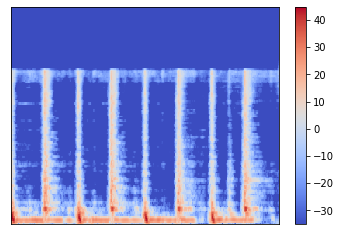

In [4]:
# Sample data
(t1, t2), label = trainSet[random.randint(0, len(trainSet))]
print(t1.shape, label)

from librosa import display
plt.figure()
display.specshow(t1.detach().numpy()[0])
print(t1.max(), t1.min(), t1.mean(), t1.max()-t1.min())
plt.colorbar()

# Model

## SiameseNet + Contrastive Loss

In [5]:
import  torch
import  torch.nn    as  nn
import  torch.nn.functional as F

# GPU Settings
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda") 
else:
    print("Using CPU")
    device = torch.device("cpu")

class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        dropout_rate = 0.1

        # Based on the model architecture described in the original paper
        # Chen, B.-Y., Smith, J. B. L. and Yang, Y.-H. (2020) ‘Neural Loop Combiner: Neural Network Models for Assessing the Compatibility of Loops’. 
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2),  # 64@96*96
            nn.PReLU(),
            # nn.Conv2d(32, 32, 3),  # 64@96*96
            # nn.ReLU(),
            nn.MaxPool2d(3),  # 64@48*48
            nn.Conv2d(16, 16, 3, stride=1),
            nn.PReLU(),    # 128@42*42
            nn.MaxPool2d(3),   # 128@21*21
#            nn.Conv2d(32, 4, 4),
#            nn.ReLU(), # 128@18*18
#            nn.MaxPool2d(2), # 128@9*9
#            nn.Conv2d(128, 256, 4),
#            nn.ReLU(),   # 256@6*6
        )
        self.fc = nn.Sequential(
            nn.Sequential(nn.Linear(1728, 1024), nn.PReLU()),
            nn.Sequential(nn.Linear(1024, 256), nn.PReLU()),
            nn.Sequential(nn.Linear(256, 4))
        )
        
    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2

Using GPU


In [6]:
# Based on https://github.com/adambielski/siamese-triplet/blob/master/losses.py
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
#        print(distances.mean(), target.mean())
            
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target.float()) * F.relu(self.margin - (distances + self.eps)))
        return losses.mean() if size_average else losses.sum()

    def forward_accuracy(self, output1, output2, target):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        # print(distances)
        
        far_enough = (self.margin * 0.5 < (distances + self.eps))
        target = target.squeeze()
        accuracy = torch.count_nonzero(far_enough[target == 0])/target[ target == 0 ].nelement()
        return accuracy




In [9]:
# Model Initialization

net = Siamese()
#print(net)

margin = 5.0
loss_fn = ContrastiveLoss(margin)
net.to(device)

Siamese(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1728, out_features=1024, bias=True)
      (1): PReLU(num_parameters=1)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=4, bias=True)
    )
  )
)

In [10]:
for batch in valLoader:

    (input1, input2), labels = batch
    input1 = input1.to(device)
    input2 = input2.to(device)
    print(labels.shape)
    labels = labels.to(device)

    output1, output2 = net(input1, input2)
    print(output1.shape)
    loss = loss_fn(output1, output2, labels)
    print("loss", loss.data.item(), loss.item())
    accuracy = loss_fn.forward_accuracy(output1, output2, labels)
    print(accuracy)
    break


torch.Size([32, 1])
torch.Size([32, 4])
loss 1.3455111980438232 1.3455111980438232
tensor(0., device='cuda:0')


In [71]:
# model summary
from torchsummary import summary

(t1, t2), label = trainSet[0]
print(t1.shape)
summary(net.cuda(), [(1, 128, 345),(1, 128, 345)])

torch.Size([1, 128, 345])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 63, 172]             160
             PReLU-2          [-1, 16, 63, 172]               1
         MaxPool2d-3           [-1, 16, 21, 57]               0
            Conv2d-4           [-1, 16, 19, 55]           2,320
             PReLU-5           [-1, 16, 19, 55]               1
         MaxPool2d-6            [-1, 16, 6, 18]               0
            Linear-7                 [-1, 1024]       1,770,496
             PReLU-8                 [-1, 1024]               1
            Linear-9                  [-1, 256]         262,400
            PReLU-10                  [-1, 256]               1
           Linear-11                    [-1, 4]           1,028
           Conv2d-12          [-1, 16, 63, 172]             160
            PReLU-13          [-1, 16, 63, 172]               1
        MaxPo

# Training

In [11]:
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Training loop
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    best_val_loss = 10000.0

    for epoch in range(epochs):
        print("Epoch: ", epoch)
        training_loss = 0.0
        valid_loss, valid_acc = 0.0, 0.0

        model.train() # 学習モードにセット　DropoutLayerなどが有効に

        for batch in tqdm(train_loader):
            optimizer.zero_grad() # 一旦リセット

            (input1, input2), labels = batch
            input1 = input1.to(device)
            input2 = input2.to(device)
            labels = labels.to(device)

            output1, output2 = model(input1, input2)

            # print(labels.shape, output.shape)
            # print(labels, output)   
            loss = loss_fn(output1, output2, labels)
            training_loss += loss.item()

            loss.backward() # back propagation - gradientの計算
            optimizer.step()
        training_loss /= len(train_loader) # average

        model.eval() # 学習モードをオフ　DropoutLayerなどが無効に モデルのパラメータはアップデートされない
        for batch in tqdm(val_loader):

            (input1, input2), labels = batch
            input1 = input1.to(device)
            input2 = input2.to(device)
            labels = labels.to(device)

            output1, output2 = model(input1, input2)

            loss = loss_fn(output1, output2, labels)
            valid_loss += loss.item()

#             acc = loss_fn.forward_accuracy(output1, output2, labels)
#             valid_acc += acc.data.item()

        valid_loss /= len(val_loader)
#        valid_acc /= len(val_loader)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, Accuracy = {:.2f}'
            .format(epoch, training_loss, valid_loss, valid_acc))
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            torch.save(net.state_dict(), "./tmp/model_const_epoch_%d_val_%.4f_acc_%.4f.pt" % (epoch, valid_loss, valid_acc))
            print("      saved in Epoch: {}".format(epoch))

In [12]:
net.train()

optimizer = torch.optim.Adam(net.parameters(),lr = 0.0001)
optimizer.zero_grad()

train(net, optimizer, loss_fn, trainLoader, valLoader, epochs=100, device=device)


Epoch:  0


100%|██████████| 108/108 [00:23<00:00,  4.62it/s]


Epoch: 0, Training Loss: 1.26, Validation Loss: 1.25, Accuracy = 0.00
      saved in Epoch: 0
Epoch:  1


 86%|████████▌ | 1064/1237 [10:44<01:44,  1.65it/s]


KeyboardInterrupt: 



# Test

In [50]:
torch.save(net.state_dict(), './tmp/weigtht.pt')

In [ ]:
import IPython.display
IPython.display.Audio("sample.wav")

path1, path2 = random.choice(valSet.positives)




In [ ]:
from torchsummary import summary

(t1, t2), label = trainSet[0]

print(t1.shape)

summary(net.cuda(), [(1, 128, 173),(1, 128, 173)])

#net.forward(t1, t2)
#print(t1.mean(axis=0).shape)
net.cuda().forward(t1.unsqueeze(0).cuda(), t2.unsqueeze(0).cuda())

torch.Size([1, 128, 173])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 126, 171]             640
              ReLU-2         [-1, 64, 126, 171]               0
            Conv2d-3          [-1, 4, 124, 169]           2,308
              ReLU-4          [-1, 4, 124, 169]               0
            Linear-5                 [-1, 1024]      85,836,800
           Sigmoid-6                 [-1, 1024]               0
            Linear-7                  [-1, 512]         524,800
           Sigmoid-8                  [-1, 512]               0
            Linear-9                  [-1, 256]         131,328
          Sigmoid-10                  [-1, 256]               0
           Conv2d-11         [-1, 64, 126, 171]             640
             ReLU-12         [-1, 64, 126, 171]               0
           Conv2d-13          [-1, 4, 124, 169]           2,308
             

tensor([[-0.0040]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
#torch.cuda.empty_cache()

In [139]:
a = torch.ones((1), device='cuda', requires_grad=False)
print(a.detach().item())
# na = a.detach().to('cpu').numpy()
# na[0][0]=10
# print(a)

1.0
